In [12]:
import os

from dotenv import load_dotenv
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    BaseMessage
)
from IPython.display import display, Image
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchRun

load_dotenv()

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")

model = ChatOpenAI(model=LITE_MODEL, base_url=LITE_LLM_URL, api_key=LITE_LLM_API_KEY)

class State(TypedDict):
    messages: Annotated[list, add_messages]


search = DuckDuckGoSearchRun()
tools = [search]



generate_prompt = SystemMessage(
    """You are an essay assistant tasked with writing excellent 3-paragraph
    essays."""
    "Generate the best essay possible for the user's request."
    """If the user provides critique, respond with a revised version of your
    previous attempts.
    """
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}


reflection_prompt = SystemMessage(
    """You are a teacher grading an essay submission. Generate critique and
    recommendations for the user's submission."""
    """Provide detailed recommendations, including requests for length, depth,
    style, etc."""
)

def reflect(state: State) -> State:
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    print(f"CLS MAP -> {cls_map}")
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content) for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    return {"messages": [HumanMessage(content=answer.content)]}


def should_continue(state: State) -> Literal["reflect", "__end__"]:
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    else:
        return "reflect"


builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()


msg = {
    "messages": [HumanMessage("write about london")]
}

for c in graph.stream(msg):
    print(c)



{'generate': {'messages': [AIMessage(content="London, the capital city of England and the United Kingdom, is a vibrant metropolis known for its rich history, diverse culture, and economic significance. With origins dating back to Roman times, London boasts a unique blend of the ancient and the modern. Iconic landmarks such as the Tower of London, Buckingham Palace, and the Houses of Parliament reflect its historical importance, while contemporary structures like The Shard and the London Eye represent its dynamic growth. The city's ability to seamlessly fuse its historical heritage with cutting-edge architecture exemplifies the resilience and adaptability of London as a global city.\n\nThe cultural diversity of London is one of its most distinctive features, with over 300 languages spoken within its borders. This multiculturalism is celebrated through various festivals, cuisines, and art forms. Institutions like the British Museum and the Tate Modern showcase not only local but also glo

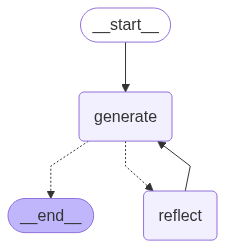

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))